In [1]:
import os
import sys
import importlib
import pickle
import emcee
import corner
AbsPath = str(os.path.abspath(""))+"/.."
sys.path.append(AbsPath)
#from Scripts.Plots import SDSS_Plots
import scipy.stats
from itertools import cycle
#Add_SDSS = SDSS_Plots.SDSS_Plots(11.5,15,0.1)
import matplotlib.pyplot as plt
from Functions import Functions as F
HMF_fun = F.Make_HMF_Interp()
from Functions.Functions import Make_HMF_Interp
import numpy as np
import matplotlib.pyplot as plt
import colossus.halo.mass_adv as massdefs
from colossus.halo.mass_so import M_to_R
from halotools import empirical_models
from colossus.cosmology import cosmology
cosmology.setCosmology("planck15")
from astropy.cosmology import Planck15 as Cosmo_AstroPy
Cosmo =cosmology.getCurrent()


h = Cosmo.h

#Abundance Matching Parameters
Override =\
{\
'M10':12.0,\
'SHMnorm10':0.032,\
'beta10':1.5,\
'gamma10':0.56,\
'M11':0.6,\
'SHMnorm11':-0.014,\
'beta11':-2,\
'gamma11':0.08\
}


AbnMtch =\
{\
'Behroozi13': False,\
'Behroozi18': False,\
'B18c':False,\
'B18t':False,\
'G18':False,\
'G18_notSE':False,\
'G19_SE':False,\
'G19_cMod':False,\
'Lorenzo18':False,\
'Moster': False,\
'Moster10': False,\
'Illustris': False,\
'z_Evo':True,\
'Scatter': 0.15,\
'Override_0': False,\
'Override_z': False,\
'Override': Override,\
'PFT': False,\
'M_PFT1': False,\
'M_PFT2': False,\
'M_PFT3': False,\
'N_PFT1': False,\
'N_PFT2': False,\
'N_PFT3': False,\
'b_PFT1': False,\
'b_PFT2': False,\
'b_PFT3': False,\
'g_PFT1': False,\
'g_PFT2': False,\
'g_PFT3': False,\
'g_PFT4': False\
}

Paramaters = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1,\
'NormRnd': 0.5,\
'SFR_Model': 'CE',\
'PreProcessing': False,\
'AltDynamicalTimeB': False\
}



#Subhalomass function parameters macc/M0
Unevolved = {\
'gamma' : 0.22,\
'alpha' : -0.91,\
'beta' : 6,\
'omega' : 3,\
'a' : 1,\
}

In [ ]:
importlib.reload(F)

In [ ]:
#Load Tinker_HOD
Tkr_hod = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_hod.dat", skiprows=2).T
Tkr_RX2 = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_RX2.dat", skiprows=2).T
#Load STEEL
Fit = ('1.0', True, True, True, 'G19_DPL', 'G19_SE')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)



#Plot Full STEEL
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

AbnMtch[Fit[5]] = True
Central_Wt = HMF_fun(AvaHaloMass[Data_z_ix], 0.5)
SM = F.DarkMatterToStellarMass(AvaHaloMass[Data_z_ix]-np.log10(h), 0.5, Paramaters, ScatterOn=False)
Norm = scipy.stats.norm(SM, 0.15)
Prob = 1-Norm.cdf(11.45)
Central_Wt = Central_Wt*Prob
X_cen, Y_cen = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Central_Wt, Scatt = 0.1)
Y_cen = Y_cen*(10**4)
AbnMtch[Fit[5]] = False

#X_sat==X_cen
plt.plot(X_sat, Y_cen+Y_sat, "-",label ="STEEL", color = "C0")
plt.plot(X_cen, Y_cen, "--",label ="STEEL_cen", color = "C0")
plt.plot(X_sat, Y_sat, ":",label = "STEEL_sat", color = "C0")



#Central only toy model
Override['M10'] = 12.0
Override['SHMnorm10'] = 0.032
Override['beta10'] = 1.5
Override['gamma10'] = 0.58
Override['M11'] = 0.6
Override['SHMnorm11'] = -0.014
Override['beta11'] = -0.7
Override['gamma11'] = 0.08

AbnMtch['Override_z'] = True
Central_Wt = HMF_fun(AvaHaloMass[Data_z_ix], 0.5)
SM = F.DarkMatterToStellarMass(AvaHaloMass[Data_z_ix]-np.log10(h), 0.5, Paramaters, ScatterOn = False)
Norm = scipy.stats.norm(SM, 0.1)
Prob = 1-Norm.cdf(11.45)
Central_Wt = Central_Wt*Prob
X_cen, Y_cen = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Central_Wt, Scatt = 0.1)
Y_cen = Y_cen*(10**4)
AbnMtch['Override_z'] = False

plt.plot(X_cen, Y_cen, "--",label ="ToyMod", color = "C2")


#"""
plt.plot(Tkr_hod[0], Tkr_hod[1]+(Tkr_hod[2]/10), "-",label = "HOD", color = "C1")
plt.plot(Tkr_hod[0], Tkr_hod[1], "--",label = "HOD_cen", color = "C1")
plt.plot(Tkr_hod[0], Tkr_hod[2]/10, ":",label = "HOD_sat", color = "C1")
#"""
"""
plt.plot(Tkr_RX2[0], Tkr_RX2[1]+(Tkr_RX2[2]/10), "-",label = "HOD", color = "C2")
plt.plot(Tkr_RX2[0], Tkr_RX2[1], "--",label = "HOD_cen", color = "C2")
plt.plot(Tkr_RX2[0], (Tkr_RX2[2]/10), ":",label = "HOD_sat", color = "C2")
"""

plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.legend(frameon = False)
plt.show()



In [ ]:
#Load Tinker_HOD
Tkr_hod = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_hod.dat", skiprows=2).T
Tkr_RX2 = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_RX2.dat", skiprows=2).T


#Load STEEL
Fit = ('1.0', False, False, True, 'G19_DPL', 'Moster')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, ":",label = "STEEL_Moster_frz", color = "C1")

#Load STEEL
Fit = ('1.0', True, True, True, 'G19_DPL', 'G19_SE')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, ":",label = "STEEL_SE_evo", color = "C2")

#Load STEEL
Fit = ('1.0', False, False, True, 'G19_DPL', 'G19_SE')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, ":",label = "STEEL_SE_evo", color = "C3")

#Load STEEL
Fit = ('1.0', False, False, True, 'G19_DPL', 'G19_cMod')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

#X_sat==X_cen
#plt.plot(X_sat, Y_cen+Y_sat, "-",label ="STEEL", color = "C0")
#plt.plot(X_cen, Y_cen, "--",label ="STEEL_cen", color = "C0")
plt.plot(X_sat, Y_sat, ":",label = "STEEL_cMod_frz", color = "C4")

#"""
#plt.plot(Tkr_hod[0], Tkr_hod[1]+(Tkr_hod[2]/10), "-",label = "HOD", color = "C1")
#plt.plot(Tkr_hod[0], Tkr_hod[1], "--",label = "HOD_cen", color = "C1")
plt.plot(Tkr_hod[0], Tkr_hod[2]/10, ":",label = "HOD_sat", color = "C0")
"""
"""
#plt.plot(Tkr_RX2[0], Tkr_RX2[1]+(Tkr_RX2[2]/10), "-",label = "HOD", color = "C2")
#plt.plot(Tkr_RX2[0], Tkr_RX2[1], "--",label = "HOD_cen", color = "C2")
plt.plot(Tkr_RX2[0], (Tkr_RX2[2]/10), ":",label = "HOD_sat_RX2", color = "C7")
#"""

plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.legend(frameon = False)
plt.show()



In [ ]:
def ReturnCentralDist(HM_range, theta):
    Gamma, Gamma_z, Scatter = theta
    #Central only toy model
    #Args:
    #    HM_range: [Msun h-1]
    #    Gamma: SMHM high mass slope parameter
    #    Gamma_z: SMHM high mass slope evolution parameter
    #    Scatter: SMHM scatter parameter
    #Returns:
    #    Y_cen: Numberdensity of central galaxies above 10^11 as a fucntion of halo mass [h^3Mpc^{-3}dex^{-1}]x10^{-4}
    """
    Override['M10'] = 12.0
    Override['SHMnorm10'] = 0.032
    Override['beta10'] = 1.5
    Override['gamma10'] = Gamma#0.525
    Override['M11'] = 0.6
    Override['SHMnorm11'] = -0.014
    Override['beta11'] = -0.7
    Override['gamma11'] = Gamma_z#0.08
    """
    Override_lcl =\
    {\
    'M10':12.0,\
    'SHMnorm10':0.032,\
    'beta10':1.5,\
    'gamma10':Gamma,\
    'M11':0.6,\
    'SHMnorm11':-0.014,\
    'beta11':-0.7,\
    'gamma11':Gamma_z\
    }
    
    
    AbnMtch_lcl =\
    {\
    'Behroozi13': False,\
    'Behroozi18': False,\
    'B18c':False,\
    'B18t':False,\
    'G18':False,\
    'G18_notSE':False,\
    'G19_SE':False,\
    'G19_cMod':False,\
    'Lorenzo18':False,\
    'Moster': False,\
    'Moster10': False,\
    'Illustris': False,\
    'z_Evo':True,\
    'Scatter': 0.15,\
    'Override_0': False,\
    'Override_z': False,\
    'Override': Override_lcl,\
    'PFT': False,\
    'M_PFT1': False,\
    'M_PFT2': False,\
    'M_PFT3': False,\
    'N_PFT1': False,\
    'N_PFT2': False,\
    'N_PFT3': False,\
    'b_PFT1': False,\
    'b_PFT2': False,\
    'b_PFT3': False,\
    'g_PFT1': False,\
    'g_PFT2': False,\
    'g_PFT3': False,\
    'g_PFT4': False\
    }

    Paramaters_lcl = \
    {\
    'AbnMtch' : AbnMtch_lcl,\
    'AltDynamicalTime': 1,\
    'NormRnd': 0.5,\
    'SFR_Model': 'CE',\
    'PreProcessing': False,\
    'AltDynamicalTimeB': False\
    }
    
    AbnMtch_lcl['Override_z'] = True
    Central_Wt = HMF_fun(HM_range, 0.5)
    SM = F.DarkMatterToStellarMass(HM_range - np.log10(h), 0.5, Paramaters_lcl, ScatterOn = False)
    Norm = scipy.stats.norm(SM, Scatter)
    Prob = 1-Norm.cdf(11.45)
    Central_Wt = Central_Wt*Prob
    X_cen, Y_cen = F.Gauss_Scatt(HM_range, Central_Wt, Scatt = 0.1)
    Y_cen = Y_cen*(10**4)
    AbnMtch_lcl['Override_z'] = False
    return Y_cen

In [ ]:
#Load Tinker_HOD
Tkr_hod = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_hod.dat", skiprows=2).T
Tkr_RX2 = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_RX2.dat", skiprows=2).T
plt.plot(Tkr_hod[0], Tkr_hod[1], ":",label = "HOD_sat", color = "C0")
theta = 0.55, 0.0, 0.1
Y = ReturnCentralDist(Tkr_hod[0], theta)



plt.plot(Tkr_hod[0], Y, label = "ToyMod", color = "C1")
plt.legend(frameon = False)
plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.show()

In [ ]:
gt12 = np.digitize(12, bins = Tkr_hod[0])-1
theta = 0.55, 0.0, 0.1
plt.plot(Tkr_hod[0][gt12:], Tkr_hod[1][gt12:], ":",label = "HOD_sat", color = "C0")


theta = 0.55, 0.0, 0.1
RMS = lnlike(theta, Tkr_hod[0][gt12:], Tkr_hod[1][gt12:])
Y = ReturnCentralDist(Tkr_hod[0][gt12:], theta)
plt.plot(Tkr_hod[0][gt12:], Y, label = str(theta)+str(round(RMS, 3)), color = "C1")


theta = 0.6, 0.0, 0.1
RMS = lnlike(theta, Tkr_hod[0][gt12:], Tkr_hod[1][gt12:])
Y = ReturnCentralDist(Tkr_hod[0][gt12:], theta)
plt.plot(Tkr_hod[0][gt12:], Y, label = str(theta)+str(round(RMS, 3)), color = "C2")


theta = 0.65, 0.0, 0.1
RMS = lnlike(theta, Tkr_hod[0][gt12:], Tkr_hod[1][gt12:])
Y = ReturnCentralDist(Tkr_hod[0][gt12:], theta)
plt.plot(Tkr_hod[0][gt12:], Y, label = str(theta)+str(round(RMS, 3)), color = "C3")


theta = 0.8, 0.0, 0.1
RMS = lnlike(theta, Tkr_hod[0][gt12:], Tkr_hod[1][gt12:])
Y = ReturnCentralDist(Tkr_hod[0][gt12:], theta)
plt.plot(Tkr_hod[0][gt12:], Y, label = str(theta)+str(round(RMS, 3)), color = "C4")

plt.legend(frameon = False)
plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.show()

In [ ]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [0.6, 0.0, 0.1], args=(Tkr_hod[0], Tkr_hod[1]))
result["x"]

In [ ]:
theta = 10, 10, 0.1
lnlike(theta, Tkr_hod[0][gt12:], Tkr_hod[1][gt12:])

In [ ]:
#MCMC Functions

#This is the likelyhood function
def lnlike(theta, HM, y):
    g, g_z, s = theta
    model = ReturnCentralDist(HM, theta)
    
    return -0.5*np.power(sum(y-model), 2)
    
    #RMS = 1 - np.divide(np.sqrt(np.sum(np.power(model-y, 2))), len(y))
    #return np.log(RMS)

#This is the log-prior function
def lnprior(theta):
    g, g_z, s = theta
    if (0.55<g<0.57) and (-0.2<g_z<0.2) and (0.01<s<0.2):
        return 0.0
    else:
        return -np.inf
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [ ]:
#set up initial conditions
ndim, nwalkers = 3, 100
pos = [[0.55,0.0, 0.1] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(Tkr_hod[0][gt12:], Tkr_hod[1][gt12:]), threads = 20)

In [ ]:
sampler.run_mcmc(pos, 500)
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$g$", "$g_z$", "$s$"])
fig.show()
#fig.savefig("triangle.png")

In [ ]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$g$", "$g_z$", "$s$"], color = "C0", smooth = True)
fig.show()

In [ ]:
import pickle

In [ ]:
samples =  pickle.load(open(AbsPath+"/Data/Model/Output/Other/SMHM_Fitting/MCMC_Chain_lz.pkl", 'rb'))

M, N, b, g = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84],axis=0)))
print(M, N, b, g)
fig = corner.corner(samples, labels=["M", "N", r"$\beta$", r"$\gamma$"], truths = [M[0], N[0], b[0], g[0]],\
                    color = "C0", truth_color = "k", smooth = True, quantiles=[0.16, 0.84],\
                    show_titles = True, title_fmt= ".3f")
fig.savefig(AbsPath+"/Figures/SMHM_Fit/MCMC_plot_lz.png")
fig.savefig(AbsPath+"/Figures/SMHM_Fit/MCMC_plot_lz.pdf")
fig.show()

In [ ]:
samples =  pickle.load(open(AbsPath+"/Data/Model/Output/Other/SMHM_Fitting/MCMC_Chain_hz.pkl", 'rb'))

M, N, b, g = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84],axis=0)))
print(M, N, b, g)
fig = corner.corner(samples, labels=[r"$M_z$", r"$N_z$", r"$\beta_z$", r"$\gamma_z$"], truths = [M[0], N[0], b[0], g[0]],\
                    color = "C0", truth_color = "k", smooth = True, quantiles=[0.16, 0.84],\
                   show_titles = True, title_fmt= ".3f")
fig.savefig(AbsPath+"/Figures/SMHM_Fit/MCMC_plot_hz.png")
fig.savefig(AbsPath+"/Figures/SMHM_Fit/MCMC_plot_hz.pdf")
fig.show()

In [ ]:
Cosmo.lookbackTime(Cosmo.lookbackTime(2.0)+np.mean(10**Data['2.0']['agebins']/10**9, axis = 1), inverse = True)

In [ ]:
Cosmo.lookbackTime(Cosmo.lookbackTime(1.0)+np.mean(10**Data['1.0']['agebins']/10**9, axis = 1), inverse = True)

In [ ]:
Cosmo.lookbackTime(Cosmo.lookbackTime(0.6)+np.mean(10**Data['0.6']['agebins']/10**9, axis = 1), inverse = True)

In [ ]:
list(Emerge.keys())

In [ ]:
Emerge = h5py.File(AbsPath+"/Data/Observational/Moster_EMERGE/mainbranches.S85.h5")
for Masscut in list(Emerge.keys()):
    Switch = True
    data = Emerge[Masscut]
    Trees = list(data.keys())
    for tree_id in Trees:
        Tree = Emerge[Masscut][tree_id]
        SF = Tree['Scale_factor']
        SF_cut = np.digitize(0.2, bins = SF)+1
        SF = SF[:SF_cut]
        SM = Tree['Stellar_mass'][:SF_cut]
        SM_insitu = Tree['Insitu_mass'][:SF_cut]
        SFR = Tree['SFR'][:SF_cut]
        CenSat = Tree['Type'][:SF_cut]
        H_ID = Tree['Halo_ID'][:SF_cut]
        D_ID = Tree['Desc_ID'][:SF_cut]

        SM_growth = np.power(10, SM[0:-2]) - np.power(10, SM[1:-1])
        SMis_growth = np.power(10, SM_insitu[0:-2]) - np.power(10, SM_insitu[1:-1])
        t = Cosmo.lookbackTime((1/SF)-1)
        z = Cosmo.lookbackTime((t[1:-1] + t[0:-2])/2, inverse = True)
        delta_t = t[1:-1] - t[0:-2]
        SM_dt = SM_growth/delta_t
        SMis_dt = SMis_growth/delta_t

        if Switch:
            Shape = np.shape(CenSat)
            z_stack = z
            M_stack = np.power(10, SM[0:-2]) + np.power(10, SM[1:-1])/2
            Mis_stack = np.power(10, SM_insitu[0:-2]) + np.power(10, SM_insitu[1:-1])/2
            Mes_stack = (np.power(10, SM[0:-2]) + np.power(10, SM[1:-1])/2) - (np.power(10, SM_insitu[0:-2]) + np.power(10, SM_insitu[1:-1])/2)
            rsf_stack = np.divide(SFR[0:-2]+SFR[1:-1],2)*10**9/SM_dt
            ris_stack = SMis_dt/SM_dt
            Switch = False
        elif Shape == np.shape(CenSat):
            z_stack = np.vstack((z_stack, z))
            M_stack = np.vstack((M_stack, np.power(10, SM[0:-2]) + np.power(10, SM[1:-1])/2))
            Mis_stack = np.vstack((Mis_stack, np.power(10, SM_insitu[0:-2]) + np.power(10, SM_insitu[1:-1])/2))
            Mes_stack = np.vstack((Mes_stack, (np.power(10, SM[0:-2]) + np.power(10, SM[1:-1])/2) - (np.power(10, SM_insitu[0:-2]) + np.power(10, SM_insitu[1:-1])/2)))
            rsf_stack = np.vstack((rsf_stack, np.divide(SFR[0:-2]+SFR[1:-1],2)*10**9/SM_dt))
            ris_stack = np.vstack((ris_stack,SMis_dt/SM_dt))

In [ ]:
plt.hist(np.log10(M_stack[:,0])[np.isfinite(np.log10(M_stack[:,0]))])
plt.show()
np.log10(np.mean(M_stack[:,0][np.isfinite(np.log10(M_stack[:,0]))]))+np.log10(h)

In [ ]:
N = 3
X_z, Y_sf, Y_is = \
np.convolve(z_stack[0], np.ones((N,))/N, mode='valid'), \
np.convolve(np.mean(rsf_stack, axis = 0), np.ones((N,))/N, mode='valid'), \
np.convolve(np.mean(ris_stack, axis = 0), np.ones((N,))/N, mode='valid')

plt.plot(X_z, Y_sf, label = "SF")
plt.plot(X_z, Y_is, label = "IS")
plt.legend()
plt.ylim(0,2)
plt.xscale('log')
plt.show()

In [ ]:
plt.plot(z_stack[0], np.log10(np.mean(M_stack, axis = 0)), label = "M")
plt.plot(z_stack[0], np.log10(np.mean(Mis_stack, axis = 0)), label = "Mis")
plt.plot(z_stack[0], np.log10(np.mean(Mes_stack, axis = 0)), label = "Mes")
plt.legend()
plt.xscale('log')
plt.show()

In [2]:
import pandas as pd

In [109]:
Header = ["type", "SF", "a", "b", "c", "avg", "avg_err", "sd", "counts"]
df = pd.read_csv(AbsPath+"/Data/Observational/Behroozi_UnviM/sfh_stats/stats_a0.911185_absolute_sm_11.900_cen.dat", sep = " ", skiprows = 17, names = Header, usecols = [0,1,2,3,4,6,8,10,12])
df2 = df.pivot(index = 'SF', columns = "type", values = 'avg')
for i in df2.columns:
    df2[i] = df2[i].map(lambda x: float(str(x)[:-1]))
df2 = df2.assign(z = lambda x: (1/x.index.values)-1)

FileNotFoundError: File b'/data/pg1g15/STEEL/Notebooks/../Data/Observational/Behroozi_UnviM/sfh_stats/stats_a0.911185_absolute_sm_11.900_cen.dat' does not exist

In [108]:
df2

type,z


In [105]:
plt.plot(df2['z'], np.log10(df2['sm_mp']))
plt.xscale('log')
plt.xlim(0,3)
plt.ylim(9, 12.5)
plt.show()

KeyError: 'sm_mp'

In [99]:
z= df2['z'].values
t = Cosmo.lookbackTime(1/df2.index.values - 1)
dt = (t[:-1]-t[1:])*(10**9)
SM = df2['sm_mp'].values
SM_dt = (SM[1:]-SM[:-1])/dt
z_med = Cosmo.lookbackTime((t[:-1]+t[1:])/2, inverse = True)
SFR = df2['sfr_mp'].values*0.59 #inst mass recycling
SFR_med = (SFR[:-1] + SFR[1:])/2
Ratio = SFR_med/SM_dt

/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


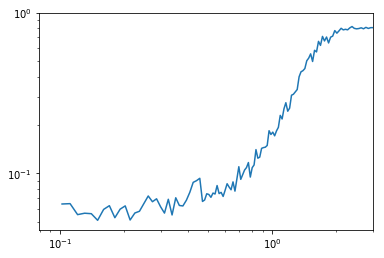

In [101]:
plt.plot(z_med, Ratio)
plt.xscale('log')
plt.yscale('log')
plt.ylim(0,1)
plt.xlim(0,3)
plt.show()

In [113]:
Acc11 = np.loadtxt(AbsPath+"/Data/Observational/Nicola_SAM/Macc_11.dat").T
Acc11pt5 = np.loadtxt(AbsPath+"/Data/Observational/Nicola_SAM/Macc_11.5.dat").T
Acc12 = np.loadtxt(AbsPath+"/Data/Observational/Nicola_SAM/Macc_12.dat").T
Main11 = np.loadtxt(AbsPath+"/Data/Observational/Nicola_SAM/Mmain_11.dat").T
Main11pt5 = np.loadtxt(AbsPath+"/Data/Observational/Nicola_SAM/Mmain_11.5.dat").T
Main12 = np.loadtxt(AbsPath+"/Data/Observational/Nicola_SAM/Mmain_12.dat").T
Ratio11 = np.loadtxt(AbsPath+"/Data/Observational/Nicola_SAM/ratio_M11.dat").T
Ratio11pt5 = np.loadtxt(AbsPath+"/Data/Observational/Nicola_SAM/ratio_M11.5.dat").T
Ratio12 = np.loadtxt(AbsPath+"/Data/Observational/Nicola_SAM/ratio_M12.dat").T

In [130]:
Main11

array([[0.15     , 0.45     , 0.75     , 1.05     , 1.35     , 1.65     ,
        1.95     , 2.25     , 2.55     , 2.85     , 3.15     , 3.45     ,
        3.75     , 4.05     , 4.35     , 4.65     , 4.95     , 5.25     ,
        5.55     , 5.85     ],
       [0.9838559, 0.8869066, 0.8131935, 0.7583365, 0.7139478, 0.7019304,
        0.6265112, 0.5561152, 0.5017625, 0.4148065, 0.3690836, 0.3364767,
        0.3140162, 0.2826168, 0.2389008, 0.2187312, 0.2146969, 0.1926727,
        0.1775979, 0.1732941],
       [0.2049314, 0.2918983, 0.3282022, 0.3735412, 0.3955397, 0.4373202,
        0.4337257, 0.4390207, 0.4209841, 0.3900911, 0.3728649, 0.3543175,
        0.3280931, 0.2909183, 0.2207582, 0.2163796, 0.2298841, 0.2036154,
        0.191839 , 0.1960521]])

In [140]:
Acc11

array([[1.5000000e-01, 4.5000000e-01, 7.5000000e-01, 1.0500000e+00,
        1.3500000e+00, 1.6500000e+00, 1.9500000e+00, 2.2500000e+00,
        2.5500000e+00, 2.8500000e+00, 3.1500000e+00, 3.4500000e+00,
        3.7500000e+00, 4.0500000e+00, 4.3500000e+00, 4.6500000e+00,
        4.9500000e+00, 5.2500000e+00, 5.5500000e+00, 5.8500000e+00],
       [3.6656837e+09, 2.1469752e+09, 1.8181938e+09, 1.6330227e+09,
        1.4775002e+09, 1.2715871e+09, 1.1965377e+09, 9.9003904e+08,
        6.5131379e+08, 5.3807565e+08, 6.7829606e+08, 7.6564262e+08,
        4.2587146e+08, 3.9228179e+08, 6.4145107e+08, 7.6441037e+08,
        1.6665390e+08, 1.4997885e+08, 1.4997885e+08, 1.4997885e+08],
       [7.9819638e+09, 2.7850094e+09, 2.5827686e+09, 1.9471547e+09,
        1.6155759e+09, 1.4461809e+09, 1.5547336e+09, 1.4816458e+09,
        1.1442939e+09, 7.1009171e+08, 6.1254054e+08, 6.5053850e+08,
        2.9335504e+08, 1.8550810e+08, 1.5001942e+08, 7.5689592e+07,
        2.0422698e+07, 0.0000000e+00, 0.000000

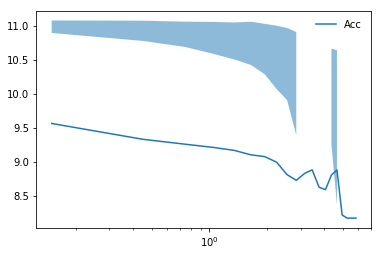

In [143]:
plt.fill_between(Main11[0], np.log10(Main11[1]-Main11[2])+11, np.log10(Main11[1]+Main11[2])+11, alpha = 0.5)
plt.plot(Acc11[0], np.log10(Acc11[1]), label = "Acc")
#plt.fill_between(Acc11[0], np.log10(Acc11[1]-Acc11[2]), np.log10(Acc11[1]+Acc11[2]), alpha = 0.5)
plt.xscale('log')
plt.legend(frameon = False)
plt.show()

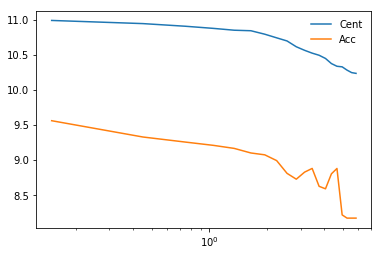

No handles with labels found to put in legend.


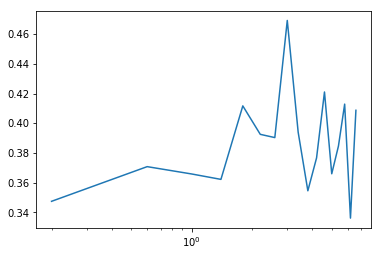

In [141]:
plt.plot(Main11[0], np.log10(Main11[1]) + 11, label = "Cent")
plt.plot(Acc11[0], np.log10(Acc11[1]), label = "Acc")
plt.xscale('log')
plt.legend(frameon = False)
plt.show()

plt.plot(Ratio11[0], Ratio11[1])
plt.xscale('log')
plt.legend(frameon = False)
plt.show()

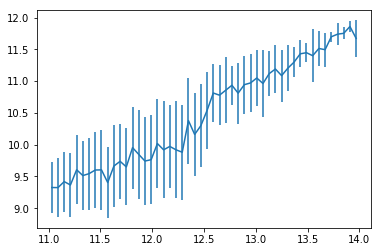

In [151]:
NM_SMHM = np.loadtxt(AbsPath+"/Data/Observational/Nicola_SAM/mstar-mhalos.dat").T
plt.errorbar(NM_SMHM[0], NM_SMHM[1], yerr = NM_SMHM[2], label = "Menci14")
plt.show()

In [146]:
NM_SMHM

array([[11.03      , 11.09      , 11.15      , 11.21      , 11.27      ,
        11.33      , 11.39      , 11.45      , 11.51      , 11.57      ,
        11.63      , 11.69      , 11.75      , 11.81      , 11.87      ,
        11.93      , 11.99      , 12.05      , 12.11      , 12.17      ,
        12.23      , 12.29      , 12.35      , 12.41      , 12.47      ,
        12.53      , 12.59      , 12.65      , 12.71      , 12.77      ,
        12.83      , 12.89      , 12.95      , 13.01      , 13.07      ,
        13.13      , 13.19      , 13.25      , 13.31      , 13.37      ,
        13.43      , 13.49      , 13.55      , 13.61      , 13.67      ,
        13.73      , 13.79      , 13.85      , 13.91      , 13.97      ],
       [ 9.325966  ,  9.324824  ,  9.418889  ,  9.365872  ,  9.605534  ,
         9.51394   ,  9.544341  ,  9.601395  ,  9.603568  ,  9.404332  ,
         9.664166  ,  9.738158  ,  9.650392  ,  9.953675  ,  9.846918  ,
         9.742396  ,  9.764312  , 10.01807   ,  9.